In [1]:
import datasets
ds = datasets.load_from_disk("./taco_cleaned_exec_filtered_max75_v3/")
ds

/home/elleven/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 7122
})

In [4]:
ds_unfiltered = datasets.load_from_disk("./taco_cleaned/")
qset = set()
for ex in ds:
    qset.add(ex["question"])

ds_disjoint = []
for ex in ds_unfiltered:
    if ex["question"] not in qset:
        ds_disjoint.append(ex)

ds_disjoint = datasets.Dataset.from_list(ds_disjoint)
ds_disjoint

Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 1889
})

In [15]:
import json
fn_name_disjoint = ds_disjoint.filter(lambda ex: "fn_name" in json.loads(ex["input_output"]))

Filter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1889/1889 [00:04<00:00, 417.60 examples/s]


In [20]:
print(fn_name_disjoint[5]["question"])

> If you've finished this kata, you can try the [more difficult version](https://www.codewars.com/kata/5b256145a454c8a6990000b5).


## Taking a walk
A promenade is a way of uniquely representing a fraction by a succession of “left or right” choices. 

For example, the promenade `"LRLL"` represents the fraction `4/7`.

Each successive choice (`L` or `R`) changes the value of the promenade by combining the values of the
promenade before the most recent left choice with the value before the most recent right choice. If the value before the most recent left choice was *l/m* and the value before the most recent right choice
was r/s then the new value will be *(l+r) / (m+s)*. 

If there has never been a left choice we use *l=1* and *m=0*;  
if there has never been a right choice we use *r=0* and *s=1*.


So let's take a walk.

* `""` An empty promenade has never had a left choice nor a right choice. Therefore we use *(l=1 and m=0)* and *(r=0 and s=1)*.  
So the value of `""` is *(1+0) / (0+1

In [5]:
total_solns = 0
for ex in ds:
    total_solns += len(ex["solutions"])

total_solns

260592

/tmp/ipykernel_26900/4160911719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)


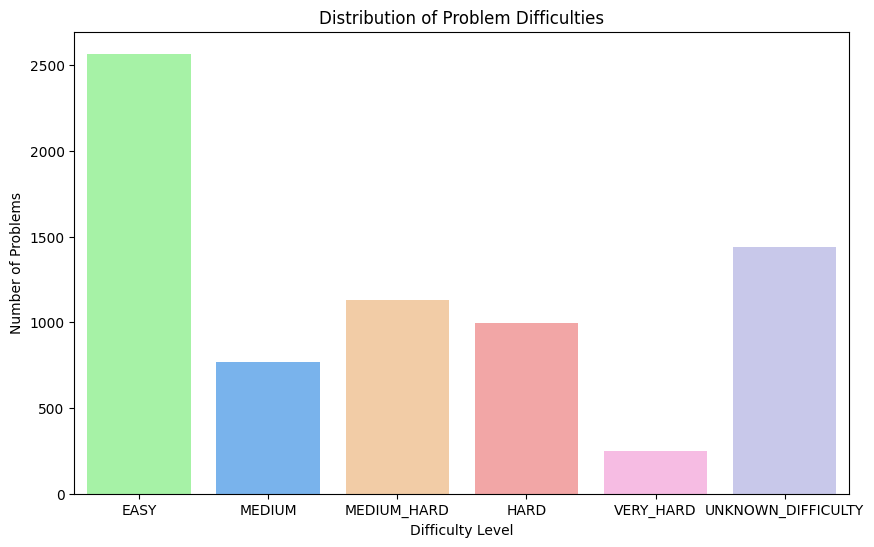

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = ds.to_pandas()

difficulty_counts = df['difficulty'].value_counts()

order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()
plt.savefig("./plots/diff_distr.png")
plt.savefig("./plots/diff_distr.pdf")

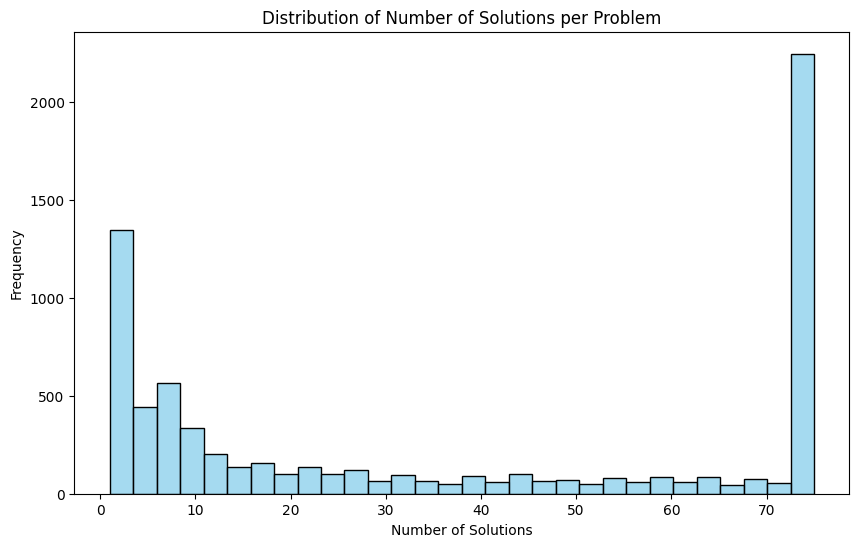

<Figure size 640x480 with 0 Axes>

In [4]:
num_solutions = ds.to_pandas()['solutions'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(num_solutions, bins=30, color='skyblue')
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Frequency')
plt.show()
plt.savefig("./plots/distr_solutions.png")
plt.savefig("./plots/distr_solutions.pdf")

Calculating BLEU Scores: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7149/7149 [25:07<00:00,  4.74it/s]


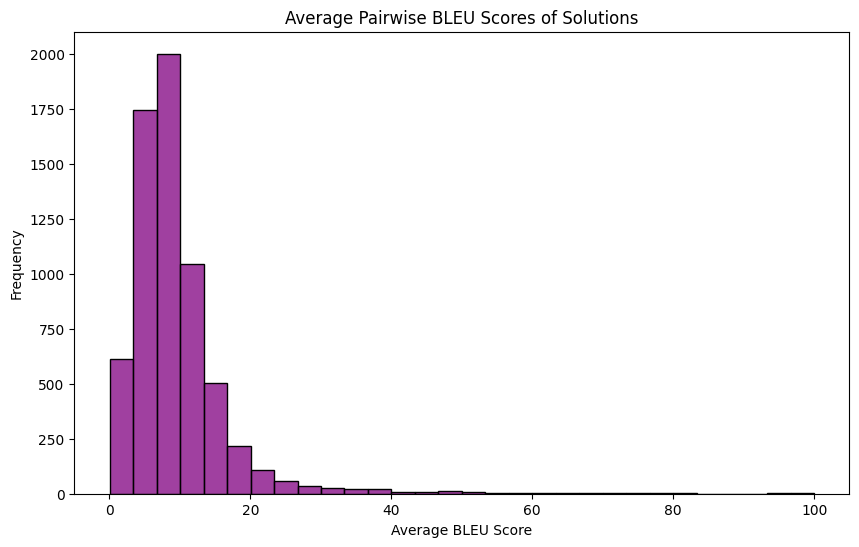

In [5]:
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas(desc="Calculating BLEU Scores")

def average_bleu_scores(solutions):
    if len(solutions) < 2:
        return np.nan
    scores = []
    for i in range(len(solutions)):
        for j in range(i + 1, len(solutions)):
            reference = solutions[i]
            candidate = solutions[j]
            score = sacrebleu.raw_corpus_bleu([candidate], [[reference]], .01).score
            scores.append(score)
    return np.mean(scores)

df = ds.to_pandas()

df['bleu_scores'] = df['solutions'].progress_apply(average_bleu_scores)

plt.figure(figsize=(10, 6))
sns.histplot(df['bleu_scores'].dropna(), bins=30, color='purple')
plt.title('Average Pairwise BLEU Scores of Solutions')
plt.xlabel('Average BLEU Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.savefig("./plots/bleu_between_solutions.png")
plt.savefig("./plots/bleu_between_solutions.pdf")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from tqdm.auto import tqdm

tqdm.pandas(desc="Tokenizing")

tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-15b")

def get_token_lengths(text):
    tokens = tokenizer.encode(text, truncation=True, max_length=2048)
    return len(tokens)

def process_solutions(solutions):
    return [get_token_lengths(solution) for solution in solutions]


question_token_lengths = ds.to_pandas()['question'].progress_apply(get_token_lengths)
solution_token_lengths = ds.to_pandas()['solutions'].progress_apply(process_solutions).explode()

combined_token_lengths = []
for question_length, solutions in zip(question_token_lengths, ds.to_pandas()['solutions']):
    combined_token_lengths.extend([question_length + len_ for len_ in process_solutions(solutions)])


Tokenizing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7149/7149 [01:22<00:00, 86.51it/s]


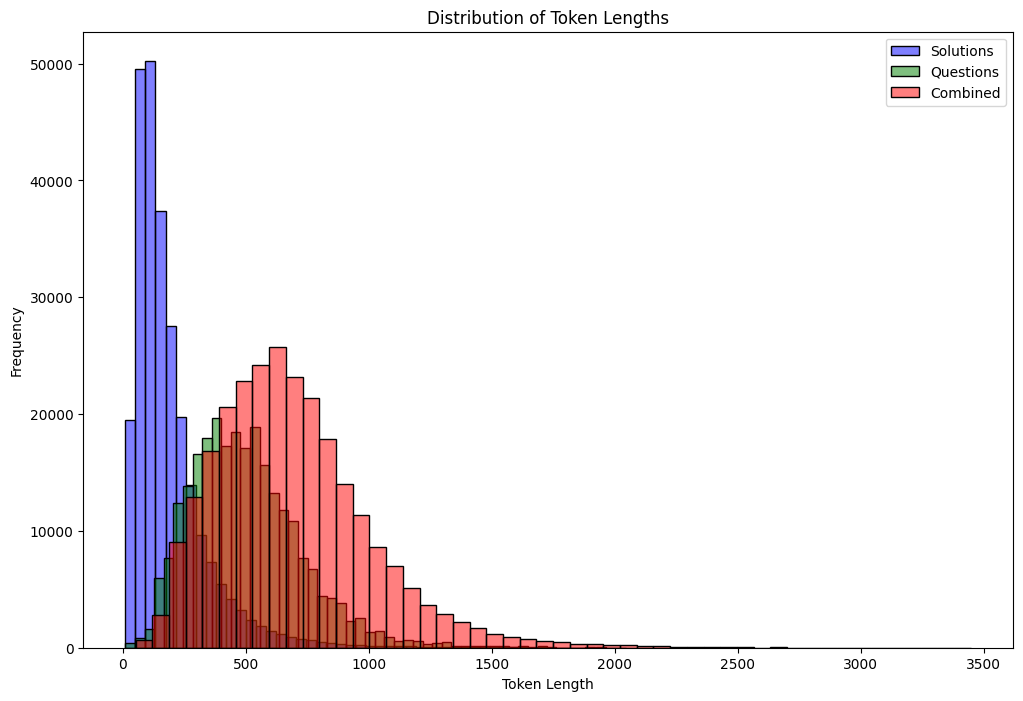

<Figure size 640x480 with 0 Axes>

In [7]:
token_lengths_df = pd.DataFrame({
    'Solution Token Lengths': solution_token_lengths,
    'Question Token Lengths': question_token_lengths,
    'Combined Token Lengths': combined_token_lengths
})

plt.figure(figsize=(12, 8))
sns.histplot(token_lengths_df['Solution Token Lengths'], bins=50, color='blue', alpha=0.5, label='Solutions')
sns.histplot(token_lengths_df['Question Token Lengths'], bins=50, color='green', alpha=0.5, label='Questions')
sns.histplot(token_lengths_df['Combined Token Lengths'], bins=50, color='red', alpha=0.5, label='Combined')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.savefig("plots/distr_tokens.png")
plt.savefig("plots/distr_tokens.pdf")

Line counts sample (pre-explode): 0                         [41, 25, 34, 40, 46, 41, 23]
1                                             [37, 24]
2             [25, 23, 17, 16, 18, 16, 17, 20, 17, 24]
3        [22, 11, 8, 16, 20, 14, 27, 9, 17, 9, 27, 13]
4    [19, 20, 22, 19, 109, 23, 19, 16, 54, 26, 25, ...
Name: solutions, dtype: object
Exploded line counts sample: 0    41
0    25
0    34
0    40
0    46
Name: solutions, dtype: int64
DataFrame with line counts:    Lines of Code
0             41
0             25
0             34
0             40
0             46


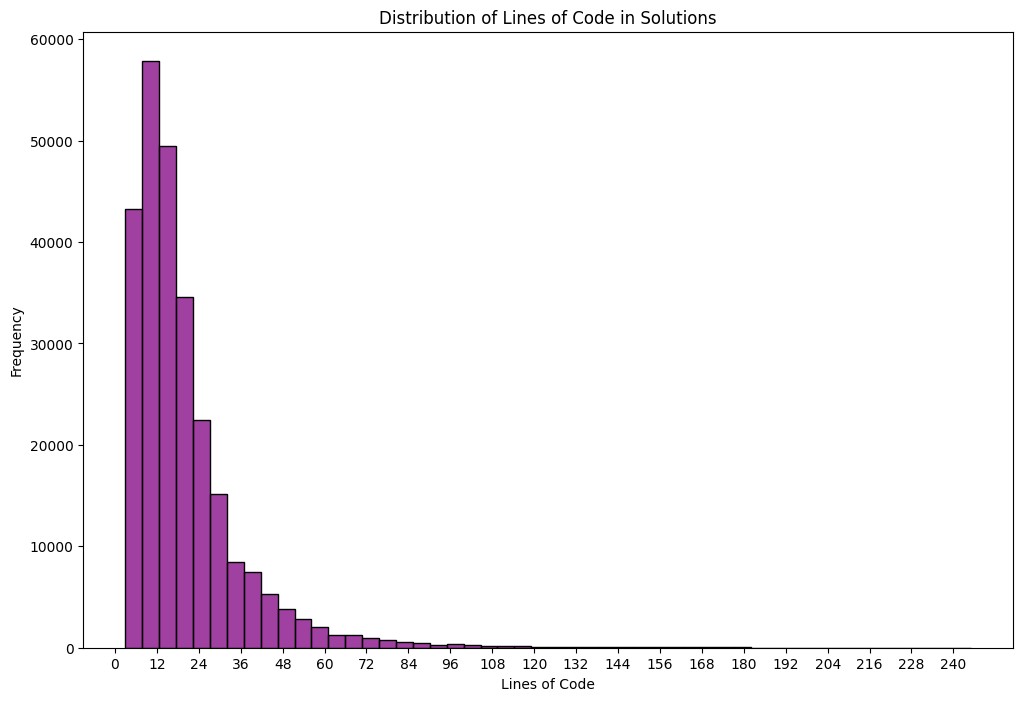

       Lines of Code
count  260040.000000
mean       19.801561
std        17.018943
min         3.000000
25%         9.000000
50%        15.000000
75%        24.000000
max       245.000000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to count lines in each solution
def count_lines(solutions):
    # +1 because the last line might not end with '\n'
    return [solution.count('\n') + 1 for solution in solutions]

# Assuming 'ds' is your dataset and is already loaded properly
# Apply line counting to 'solutions'
line_counts = ds.to_pandas()['solutions'].apply(count_lines)
print("Line counts sample (pre-explode):", line_counts.head())

# Explode the list of line counts into a flat series
exploded_line_counts = line_counts.explode().astype(int)  # Ensuring the data type is integer for plotting
print("Exploded line counts sample:", exploded_line_counts.head())

# Convert the exploded series to a DataFrame for easier handling
# This method directly uses the series as a column in the DataFrame
loc_df = pd.DataFrame({'Lines of Code': exploded_line_counts})
print("DataFrame with line counts:", loc_df.head())

# Ensure DataFrame is properly populated before plotting
if not loc_df.empty:
    # Plotting the distribution of lines of code
    plt.figure(figsize=(12, 8))
    sns.histplot(loc_df['Lines of Code'], bins=50, color='purple')

    max_val = loc_df['Lines of Code'].max()
    ticks = np.arange(0, max_val + 1, step=max_val//20)
    plt.xticks(ticks)


    plt.title('Distribution of Lines of Code in Solutions')
    plt.xlabel('Lines of Code')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("The DataFrame is empty. Check the data transformations.")

print(loc_df.describe())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to count lines in each solution
def count_lines(solution):
    return solution.count('\n') + 1  # +1 because the last line might not end with '\n'

# Assuming 'ds' is your dataset and is already loaded properly
# Calculate line counts for each solution
ds['line_counts'] = ds['solutions'].apply(lambda solutions: [count_lines(solution) for solution in solutions])

# Calculate statistics for each problem
ds['mean_loc'] = ds['line_counts'].apply(lambda x: pd.Series(x).mean())
ds['median_loc'] = ds['line_counts'].apply(lambda x: pd.Series(x).median())
ds['std_loc'] = ds['line_counts'].apply(lambda x: pd.Series(x).std())
ds['min_loc'] = ds['line_counts'].apply(lambda x: pd.Series(x).min())
ds['max_loc'] = ds['line_counts'].apply(lambda x: pd.Series(x).max())

# Ensure DataFrame is properly populated before plotting
if not ds.empty:
    # Plotting the variation of lines of code per problem
    plt.figure(figsize=(12, 8))

    # Using seaborn's barplot to show mean and standard deviation
    sns.barplot(x=ds.index, y='mean_loc', data=ds, palette='viridis', capsize=.2, errwidth=1, ci='sd')

    plt.title('Variation of Lines of Code per Problem')
    plt.xlabel('Problem ID')
    plt.ylabel('Lines of Code')
    plt.xticks(rotation=90)  # Rotate x-axis labels if there are many problems

    plt.show()
else:
    print("The DataFrame is empty. Check the data transformations.")

print(ds[['problem_id', 'mean_loc', 'median_loc', 'std_loc', 'min_loc', 'max_loc']].describe())

In [9]:
ex = ds[0]
ds.filter(lambda ex: ex["source"] == "codewars")

Filter: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7149/7149 [00:00<00:00, 24654.87 examples/s]


Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 550
})